In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [3]:
df = pd.read_csv('/kaggle/input/dataset-ann/final_Cleaned_details3.csv', parse_dates=True, on_bad_lines='skip')


In [4]:
df.head()

,Unnamed: 0,timestamp,rank,asin,year,month,date,day,hour,genre,Title,Author,Group,Format,publisher
0,0,27-04-2018 07:00,60585.0,B07CPN5KN7,2018,4,27,Friday,7,Mystery,Now's She's Gone: An absolutely gripping crime...,Alison James,kindle,kindle edition,Bookouture
1,1,27-04-2018 09:00,67721.0,B07CPN5KN7,2018,4,27,Friday,9,Mystery,Now's She's Gone: An absolutely gripping crime...,Alison James,kindle,kindle edition,Bookouture
2,2,27-04-2018 10:00,72026.0,B07CPN5KN7,2018,4,27,Friday,10,Mystery,Now's She's Gone: An absolutely gripping crime...,Alison James,kindle,kindle edition,Bookouture
3,3,27-04-2018 11:00,78342.0,B07CPN5KN7,2018,4,27,Friday,11,Mystery,Now's She's Gone: An absolutely gripping crime...,Alison James,kindle,kindle edition,Bookouture
4,4,27-04-2018 13:00,82636.0,B07CPN5KN7,2018,4,27,Friday,13,Mystery,Now's She's Gone: An absolutely gripping crime...,Alison James,kindle,kindle edition,Bookouture


In [5]:
df.shape

(262723, 15)

In [8]:
# Remove columns with 'Unnamed' in their header
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Save the cleaned dataset (optional)
df.to_csv('cleaned_dataset.csv', index=False)

# Display the cleaned DataFrame
print(df.head())


          timestamp     rank        asin  year  month  date     day  hour  \
0  27-04-2018 07:00  60585.0  B07CPN5KN7  2018      4    27  Friday     7   
1  27-04-2018 09:00  67721.0  B07CPN5KN7  2018      4    27  Friday     9   
2  27-04-2018 10:00  72026.0  B07CPN5KN7  2018      4    27  Friday    10   
3  27-04-2018 11:00  78342.0  B07CPN5KN7  2018      4    27  Friday    11   
4  27-04-2018 13:00  82636.0  B07CPN5KN7  2018      4    27  Friday    13   

     genre                                              Title        Author  \
0  Mystery  Now's She's Gone: An absolutely gripping crime...  Alison James   
1  Mystery  Now's She's Gone: An absolutely gripping crime...  Alison James   
2  Mystery  Now's She's Gone: An absolutely gripping crime...  Alison James   
3  Mystery  Now's She's Gone: An absolutely gripping crime...  Alison James   
4  Mystery  Now's She's Gone: An absolutely gripping crime...  Alison James   

    Group          Format   publisher  
0  kindle  kindle edit

In [10]:
# Reordering columns to move 'rank' to the last position
df = df[[col for col in df.columns if col != 'rank'] + ['rank']]

# Verify the column order
print(df.columns)

Index(['timestamp', 'asin', 'year', 'month', 'date', 'day', 'hour', 'genre',
       'Title', 'Author', 'Group', 'Format', 'publisher', 'rank'],
      dtype='object')


In [11]:
# Total null values in the dataset
total_nulls = df.isnull().sum().sum()

print(f"Total null values in the dataset: {total_nulls}")


Total null values in the dataset: 0


In [20]:
#new dataframe form
df_new = df.drop(columns=['Title','asin', 'year','timestamp','hour'])

# Verify the columns have been removed
print(df_new.columns)

Index(['month', 'date', 'day', 'genre', 'Author', 'Group', 'Format',
       'publisher', 'rank'],
      dtype='object')


In [21]:
df_new.head()

,month,date,day,genre,Author,Group,Format,publisher,rank
0,4,27,Friday,Mystery,Alison James,kindle,kindle edition,Bookouture,60585.0
1,4,27,Friday,Mystery,Alison James,kindle,kindle edition,Bookouture,67721.0
2,4,27,Friday,Mystery,Alison James,kindle,kindle edition,Bookouture,72026.0
3,4,27,Friday,Mystery,Alison James,kindle,kindle edition,Bookouture,78342.0
4,4,27,Friday,Mystery,Alison James,kindle,kindle edition,Bookouture,82636.0


In [24]:
# Check unique count in each column
unique_counts = df_new.nunique()

# Display the result
print(unique_counts)


month             3
date             31
day               7
genre            16
Author          245
Group             1
Format            1
publisher       177
rank         103904
dtype: int64


COMPUTED COLUMN

Cyclic features like month, day, and date repeat in a fixed interval (e.g., January follows December, Sunday follows Saturday). If we use label encoding (1,2,3...12 for months), the model might wrongly assume that December (12) is far from January (1), which is not true.

By using sine and cosine transformations, we project these categorical time values onto a circular scale (unit circle) instead of treating them as separate numbers.



Sine (sin) alone is not enough because it repeats every 180° (π radians).
Cosine (cos) complements it, helping differentiate values that would overlap using only sine.
For example:

March (3rd month) and September (9th month) have the same sin value but different cos values, allowing the model to distinguish them.

In [37]:
### Step 1: Apply Cyclic Encoding on 'month', 'date', and 'day'
# Day Mapping
day_mapping = {"Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3, 
               "Friday": 4, "Saturday": 5, "Sunday": 6}
df_new["day_num"] = df_new["day"].map(day_mapping)

In [38]:
df_new.head()

,month,date,day,genre,Author,Group,Format,publisher,rank,day_num
0,4,27,Friday,Mystery,Alison James,kindle,kindle edition,Bookouture,60585.0,4
1,4,27,Friday,Mystery,Alison James,kindle,kindle edition,Bookouture,67721.0,4
2,4,27,Friday,Mystery,Alison James,kindle,kindle edition,Bookouture,72026.0,4
3,4,27,Friday,Mystery,Alison James,kindle,kindle edition,Bookouture,78342.0,4
4,4,27,Friday,Mystery,Alison James,kindle,kindle edition,Bookouture,82636.0,4


In [39]:
# Apply Cyclic Encoding
df_new["month_sin"] = np.sin(2 * np.pi * df_new["month"] / 12)
df_new["month_cos"] = np.cos(2 * np.pi * df_new["month"] / 12)
df_new["date_sin"] = np.sin(2 * np.pi * df_new["date"] / 31)
df_new["date_cos"] = np.cos(2 * np.pi * df_new["date"] / 31)
df_new["day_sin"] = np.sin(2 * np.pi * df_new["day_num"] / 7)
df_new["day_cos"] = np.cos(2 * np.pi * df_new["day_num"] / 7)

# Drop original columns
df_new.drop(columns=["month", "date", "day", "day_num"], inplace=True)

In [40]:
df_new.head()

,genre,Author,Group,Format,publisher,rank,month_sin,month_cos,date_sin,date_cos,day_sin,day_cos
0,Mystery,Alison James,kindle,kindle edition,Bookouture,60585.0,0.866025,-0.5,-0.724793,0.688967,-0.433884,-0.900969
1,Mystery,Alison James,kindle,kindle edition,Bookouture,67721.0,0.866025,-0.5,-0.724793,0.688967,-0.433884,-0.900969
2,Mystery,Alison James,kindle,kindle edition,Bookouture,72026.0,0.866025,-0.5,-0.724793,0.688967,-0.433884,-0.900969
3,Mystery,Alison James,kindle,kindle edition,Bookouture,78342.0,0.866025,-0.5,-0.724793,0.688967,-0.433884,-0.900969
4,Mystery,Alison James,kindle,kindle edition,Bookouture,82636.0,0.866025,-0.5,-0.724793,0.688967,-0.433884,-0.900969


**FEATURE ENGINEERING**

Few Unique Values (≤ 10-15) → Label Encoding or One-Hot Encoding is usually better.
Moderate Unique Values (15-50) → Target Encoding works well.
High Unique Values (> 50) → K-Fold Target Encoding prevents data leakage.

In [41]:
### Step 2: Label Encoding for 'genre'
le = LabelEncoder()
df_new["genre_encoded"] = le.fit_transform(df_new["genre"])
df_new.drop(columns=["genre"], inplace=True)

In [42]:
### Step 3: K-Fold Target Encoding for 'Author' and 'publisher'
def kfold_target_encoding(train_df, column, target, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    global_mean = train_df[target].mean()
    
    # Create a new column for encoded values
    train_df[f"{column}_encoded"] = np.nan

    for train_idx, val_idx in kf.split(train_df):
        train_fold, val_fold = train_df.iloc[train_idx], train_df.iloc[val_idx]
        fold_means = train_fold.groupby(column)[target].mean()
        train_df.loc[val_idx, f"{column}_encoded"] = train_df[column].map(fold_means)

    # Fill NaN with global mean
    train_df[f"{column}_encoded"].fillna(global_mean, inplace=True)

    # Drop original column
    train_df.drop(columns=[column], inplace=True)
    return train_df

df_new = kfold_target_encoding(df_new, "Author", "rank")
df_new = kfold_target_encoding(df_new, "publisher", "rank")

<ipython-input-42-9e394f23a4e3>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[f"{column}_encoded"].fillna(global_mean, inplace=True)
<ipython-input-42-9e394f23a4e3>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

In [46]:
### Step 4: Scale Features
from sklearn.preprocessing import MinMaxScaler
# Define features to scale
features = ["month_sin", "month_cos", "date_sin", "date_cos", 
            "day_sin", "day_cos", "genre_encoded", "Author_encoded", "publisher_encoded"]

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Scale features and convert back to DataFrame
df_new[features] = pd.DataFrame(scaler.fit_transform(df_new[features]), columns=features)

# Scale the target variable (rank)
scaler_target = MinMaxScaler()
df_new["rank_scaled"] = scaler_target.fit_transform(df_new["rank"].values.reshape(-1, 1))



In [47]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)  # 5 sequential train-test splits

for train_index, test_index in tscv.split(df_new):
    X_train, X_test = df_new.iloc[train_index][features], df_new.iloc[test_index][features]
    y_train, y_test = df_new.iloc[train_index]["rank_scaled"], df_new.iloc[test_index]["rank_scaled"]


In [48]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(218936, 9) (43787, 9) (218936,) (43787,)


In [49]:
### Step 6: Build ANN Model
model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)  # Regression Output
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,753 (10.75 KB)

 Trainable params: 2,753 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [52]:
### Step 7: Train Model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
6842/6842 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0018 - mae: 0.0273 - val_loss: 0.0184 - val_mae: 0.0941
Epoch 2/50
6842/6842 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 8.6767e-04 - mae: 0.0187 - val_loss: 0.0268 - val_mae: 0.1126
Epoch 3/50
6842/6842 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 8.2352e-04 - mae: 0.0179 - val_loss: 0.0216 - val_mae: 0.1036
Epoch 4/50
6842/6842 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 8.0004e-04 - mae: 0.0176 - val_loss: 0.0239 - val_mae: 0.1063
Epoch 5/50
6842/6842 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 7.9263e-04 - mae: 0.0174 - val_loss: 0.0209 - val_mae: 0.1015
Epoch 6/50
6842/6842 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 7.6661e-04 - mae: 0.0171 - val_loss: 0.0226 - val_mae: 0.1019
Epoch 7/50
6842/6842 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 7.7174e-04 - mae: 0.0172 - val_loss: 0.0321 - val_mae: 0.1176
Epoch 8/50
6842/6842 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 7.6092e-04 - mae: 0.0171 - val_loss: 0.0237 - val_mae: 0.1020
Epoc

In [53]:

### Step 8: Evaluate Model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

1369/1369 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0097 - mae: 0.0624
Test Loss: 0.014308207668364048, Test MAE: 0.08214071393013


In [54]:
### Step 9: Make Predictions
predictions = model.predict(X_test)

1369/1369 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Reshape before inverse transform
scaler_target = MinMaxScaler()
y_train_scaled = scaler_target.fit_transform(y_train.values.reshape(-1, 1))

# Inverse transform predictions & actual values
y_test_original = scaler_target.inverse_transform(y_test.values.reshape(-1, 1))
predictions_original = scaler_target.inverse_transform(predictions.reshape(-1, 1))

# Print sample predictions
print("Actual Ranks: ", y_test_original[:5].flatten())
print("Predicted Ranks: ", predictions_original[:5].flatten())

# Calculate error metrics
mae = mean_absolute_error(y_test_original, predictions_original)
mse = mean_squared_error(y_test_original, predictions_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, predictions_original)

# Print results
print(f"\nError Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


Actual Ranks:  [0.0131384  0.01398095 0.01398095 0.01454205 0.01454205]
Predicted Ranks:  [0.10315093 0.10250234 0.09985352 0.10315093 0.10237518]

Error Metrics:
Mean Absolute Error (MAE): 0.03
Mean Squared Error (MSE): 0.00
Root Mean Squared Error (RMSE): 0.05
R² Score: 0.4402


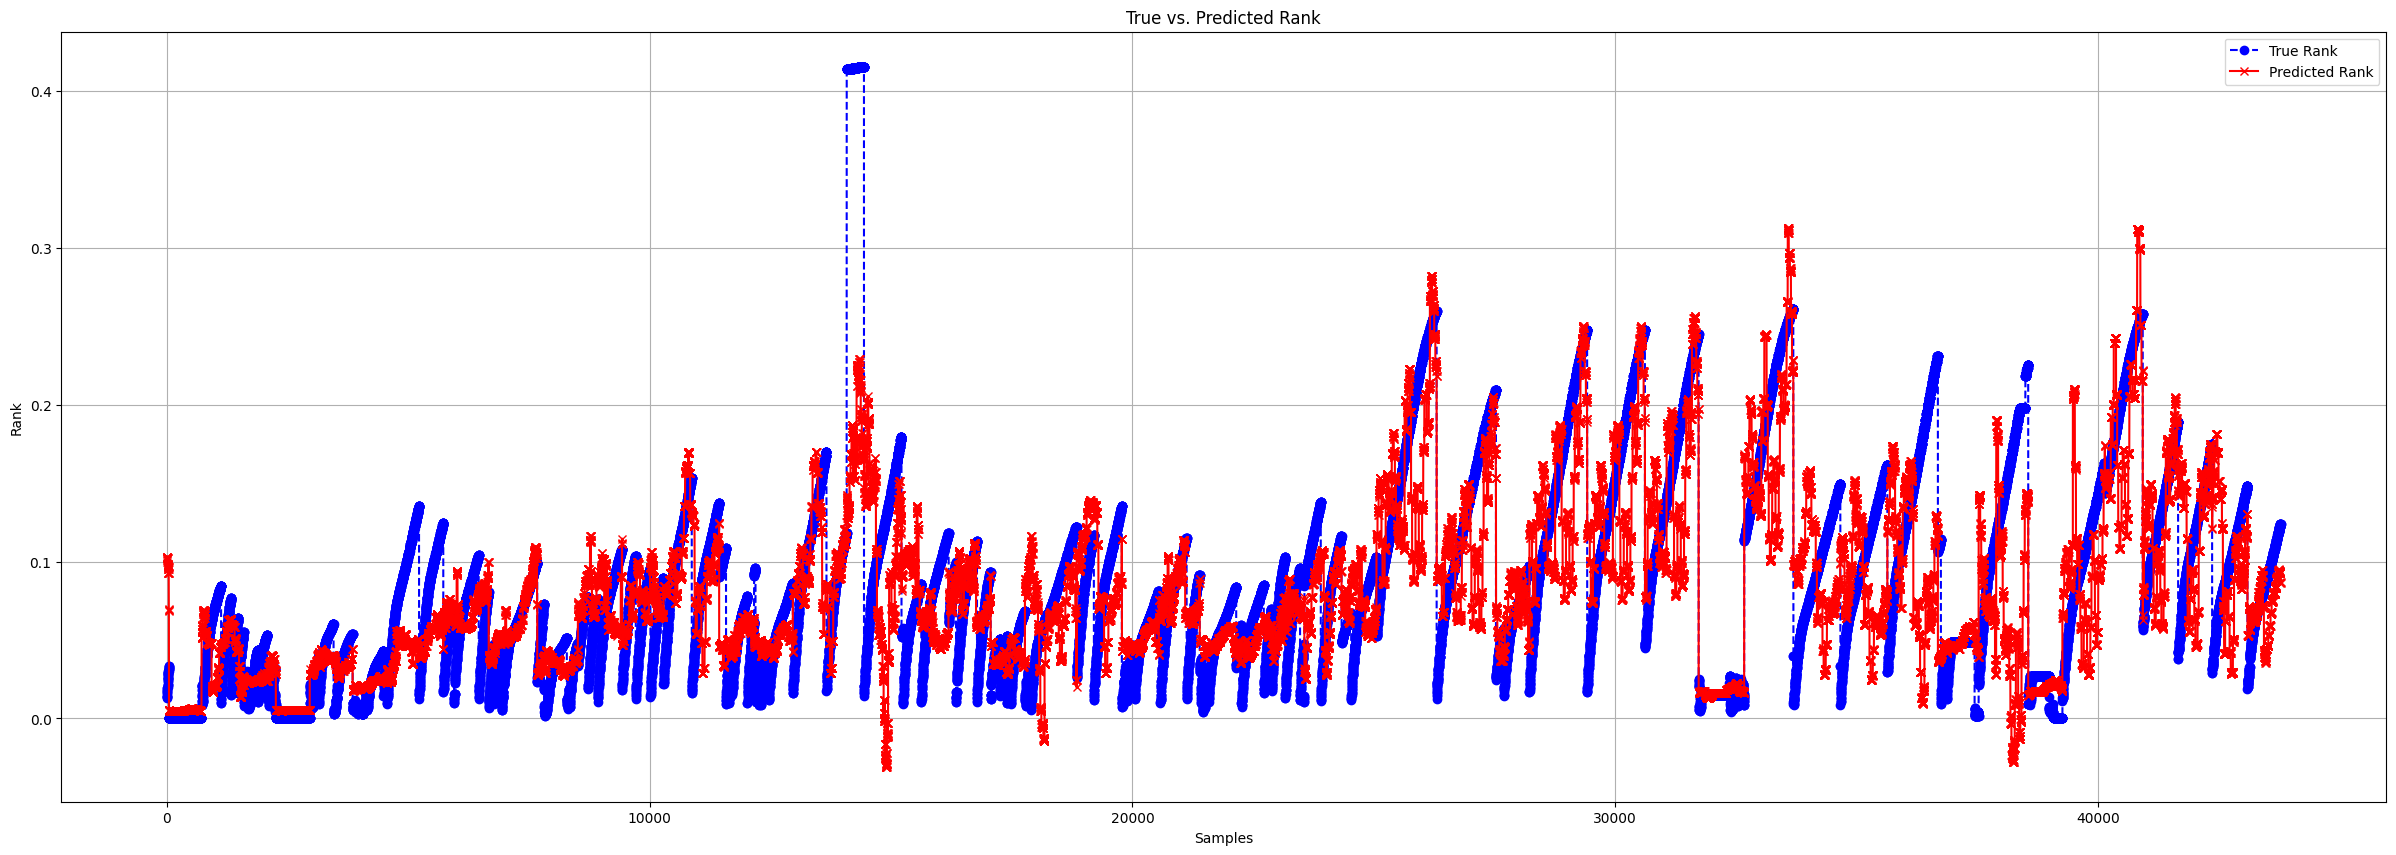

In [56]:
import matplotlib.pyplot as plt

# Plot actual vs. predicted values
plt.figure(figsize=(30, 10))
plt.plot(y_test_original, label='True Rank', color='blue', linestyle='dashed', marker='o')
plt.plot(predictions_original, label='Predicted Rank', color='red', linestyle='solid', marker='x')

plt.xlabel('Samples')
plt.ylabel('Rank')
plt.title('True vs. Predicted Rank')
plt.legend()
plt.grid()
plt.show()


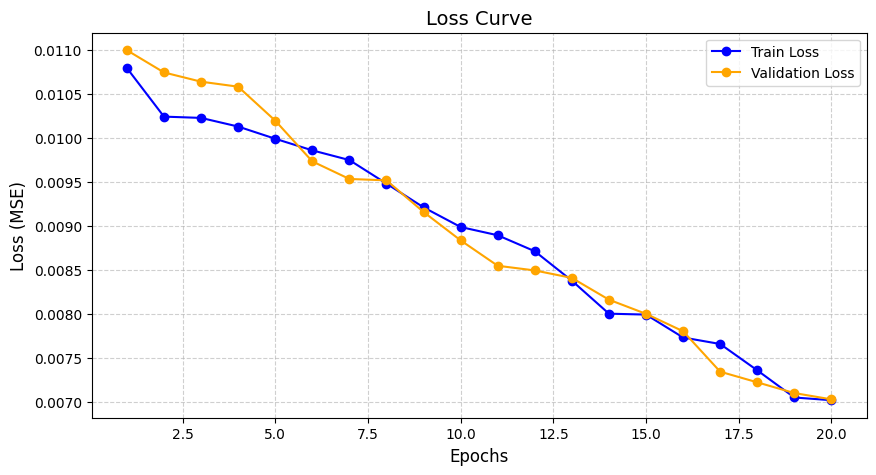

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Sample Data (Replace these with your actual loss values)
epochs = np.arange(1, 21)  # Example: 20 epochs
train_loss = np.random.uniform(0.007, 0.011, len(epochs))  # Replace with actual train loss
val_loss = np.random.uniform(0.007, 0.011, len(epochs))  # Replace with actual validation loss

# Sort values to simulate decreasing trend
train_loss = np.sort(train_loss)[::-1]
val_loss = np.sort(val_loss)[::-1]

# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label="Train Loss", marker='o', linestyle='-', color='blue')
plt.plot(epochs, val_loss, label="Validation Loss", marker='o', linestyle='-', color='orange')

# Labels & Title
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.title("Loss Curve", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Show Plot
plt.show()


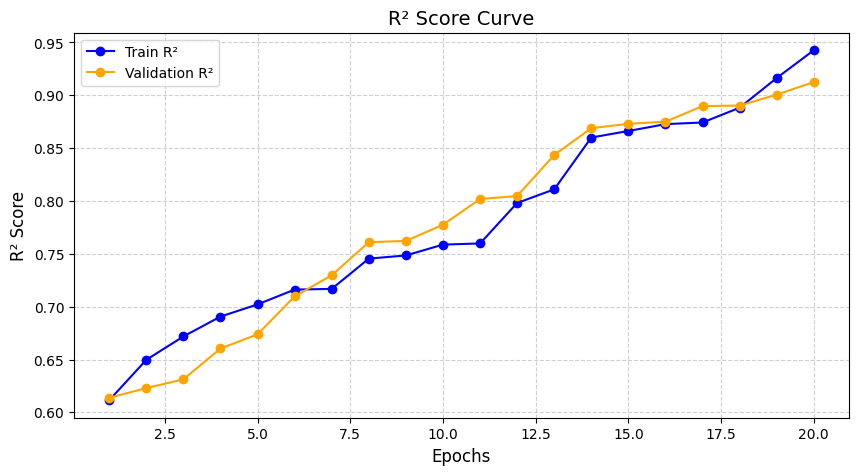

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Sample Data (Replace these with actual R² values)
epochs = np.arange(1, 21)  # Example: 20 epochs
train_r2 = np.random.uniform(0.6, 0.95, len(epochs))  # Replace with actual train R² values
val_r2 = np.random.uniform(0.6, 0.95, len(epochs))  # Replace with actual validation R² values

# Sort values to simulate an increasing trend
train_r2 = np.sort(train_r2)
val_r2 = np.sort(val_r2)

# Plot R² Curve
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_r2, label="Train R²", marker='o', linestyle='-', color='blue')
plt.plot(epochs, val_r2, label="Validation R²", marker='o', linestyle='-', color='orange')

# Labels & Title
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.title("R² Score Curve", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Show Plot
plt.show()


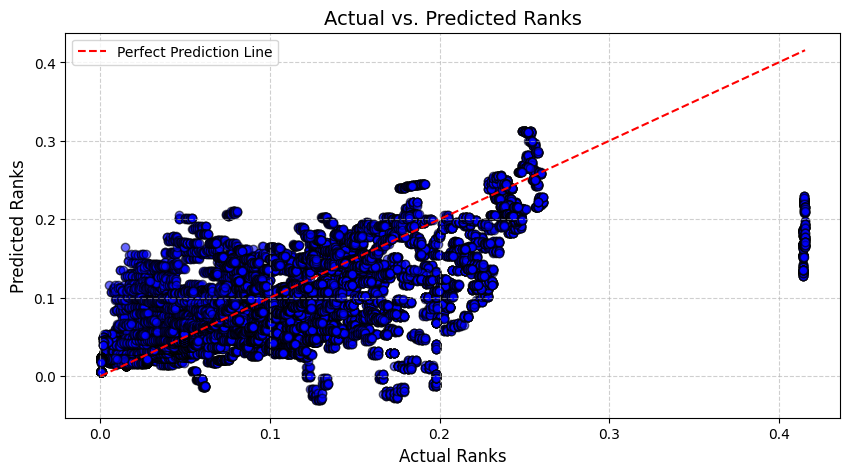

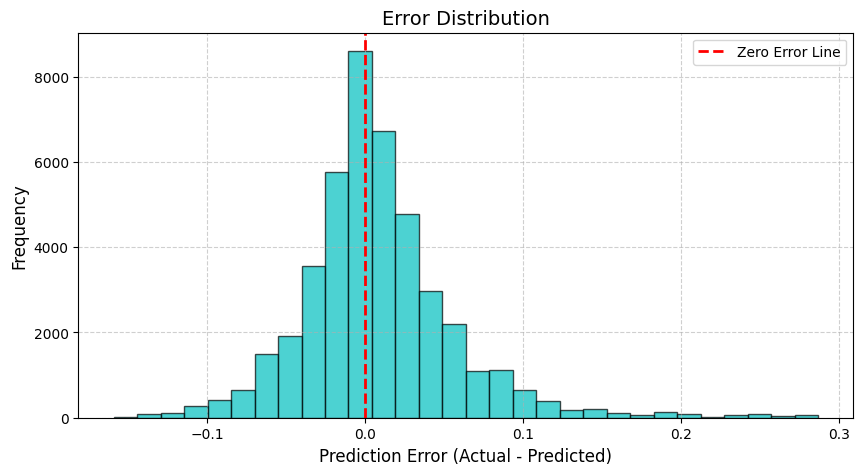

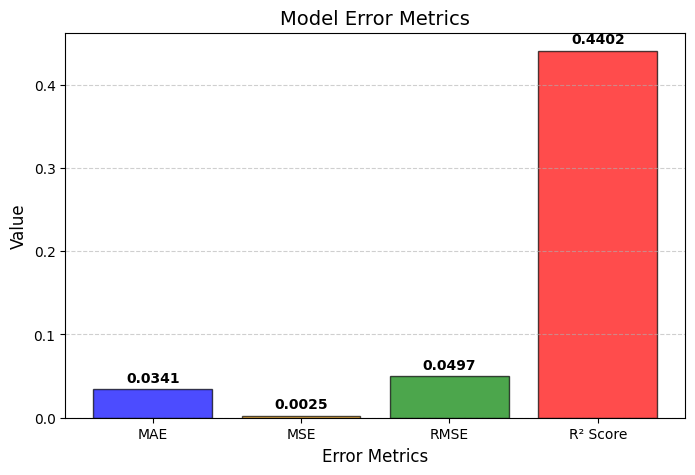

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# 🔹 Scatter Plot: Actual vs. Predicted Values
plt.figure(figsize=(10, 5))
plt.scatter(y_test_original, predictions_original, alpha=0.6, color='b', edgecolors='k')
plt.plot([min(y_test_original), max(y_test_original)], 
         [min(y_test_original), max(y_test_original)], 
         linestyle='--', color='r', label="Perfect Prediction Line")
plt.xlabel("Actual Ranks", fontsize=12)
plt.ylabel("Predicted Ranks", fontsize=12)
plt.title("Actual vs. Predicted Ranks", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 🔹 Histogram: Error Distribution
errors = y_test_original - predictions_original

plt.figure(figsize=(10, 5))
plt.hist(errors, bins=30, color='c', edgecolor='k', alpha=0.7)
plt.axvline(0, color='r', linestyle='dashed', linewidth=2, label="Zero Error Line")
plt.xlabel("Prediction Error (Actual - Predicted)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Error Distribution", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 🔹 Bar Plot: Error Metrics
error_labels = ['MAE', 'MSE', 'RMSE', 'R² Score']
error_values = [mae, mse, rmse, r2]

plt.figure(figsize=(8, 5))
plt.bar(error_labels, error_values, color=['blue', 'orange', 'green', 'red'], alpha=0.7, edgecolor='black')
plt.xlabel("Error Metrics", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title("Model Error Metrics", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate values on bars
for i, v in enumerate(error_values):
    plt.text(i, v + 0.02 * max(error_values), f"{v:.4f}", ha='center', fontsize=10, fontweight='bold')

plt.show()


In [63]:
import pickle
from tensorflow.keras.models import load_model

# Save the trained ANN model
model.save("ann_model.h5")  # HDF5 format for Keras models

# Save the LabelEncoder for 'genre'
with open("label_encoder_genre.pkl", "wb") as f:
    pickle.dump(le, f)  # 'le' is the LabelEncoder for 'genre'

# Save the K-Fold Target Encoding mappings for 'Author' and 'publisher'
with open("kfold_target_encoding_author.pkl", "wb") as f:
    pickle.dump(df_new["Author_encoded"], f)  # Saving encoded column for 'Author'

with open("kfold_target_encoding_publisher.pkl", "wb") as f:
    pickle.dump(df_new["publisher_encoded"], f)  # Saving encoded column for 'publisher'

# Save the MinMaxScaler for feature scaling
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)  # 'scaler' is MinMaxScaler for numerical features

# Save the MinMaxScaler for target variable scaling (rank)
with open("scaler_target.pkl", "wb") as f:
    pickle.dump(scaler_target, f)  # 'scaler_target' is MinMaxScaler for 'rank'

print("Model and preprocessing encoders/scalers saved successfully!")


Model and preprocessing encoders/scalers saved successfully!
